In [1]:
!pip install -r requirements.txt --quiet

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# from pennylane.optimize import COBYLA


#### Task 1 - Understanding the problem
1.1 Problem Hamiltonian:

The problem hamiltonian can be defined by for a two node graph:

$H_c = \frac 1 2(1-Z_0 \otimes Z_1)$

So lets first define out initial two node graph:


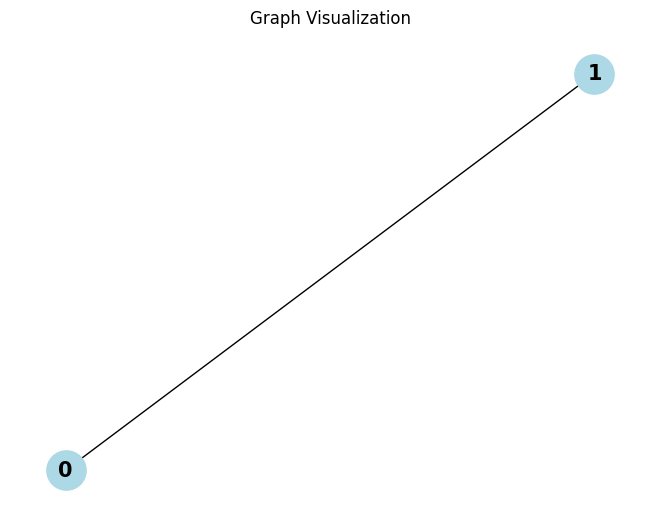

In [3]:
#define the nodes
# nodes = [0,1]
# and edges in the graph
graph = [(0,1)]

def print_graph(edges):
    G = nx.Graph()
    G.add_nodes_from({node for tup in edges for node in tup})
    G.add_edges_from(edges)

    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=800, font_size=15, font_color='black', font_weight='bold')

    plt.title("Graph Visualization")
    plt.show()


print_graph(graph)
# # create a new graph for potting
# G = nx.Graph()
# # Add nodes
# G.add_nodes_from(nodes)
# # Add edges
# G.add_edges_from(edges)

# # Draw the graph
# pos = nx.spring_layout(G)  # positions for all nodes
# nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=15, font_color='black', font_weight='bold')

# # Show the plot
# plt.title("Graph Visualization")
# plt.show()

In [4]:
# define the Hamiltonian cost function
# this includes the gamma parameter for later use when
# applying optimisation
def H_c(wires):
    # set the value of the first wire in the ciruit to
    # the first node value in the first edge
    wire1 = wires[0]
    # set the value of the second wire in the circuit to
    # the second node vlaue in the first edge 
    wire2 = wires[1]

    return 0.5 * (1 - qml.PauliZ(wire1) @ qml.PauliZ(wire2))
    # # apply CNOT gate to the wires to achieve an entangled
    # # state
    # qml.CNOT(wires=[wire1, wire2])
    # ## apply the Palui-Z rotation to the 
    # qml.RZ()
    # # apply CNOT gate again to the wire to un-entangle
    # # states
    # qml.CNOT(wires=[wire1, wire2])



1.2 The mixer hamiltonian:

In [5]:
def H_m(beta, wires):
    qml.PauliX(wires[0]) + qml.PauliX(wires[1])

## Task 2 - Setup the QAOA circuit
2.1 initialise a quantum device with `default.qubit`

In [6]:
n_wires = 2
dev = qml.device("default.qubit", wires=n_wires)

In [22]:
# def U_c(gamma, graph):

#     print(graph)

#     def apply_parameters(gamma):
        

#     def cost(gamma):
#         apply_parameters(gamma)
#         return qml.state()
    
#     return cost
    

In [64]:
#where n_wires corresponds to the number of vertices
# in the graph

# @qml.qnode(dev)
def QAOA_circuit(graph, params, n_wires, p):
    # wire0 = edges[0][0]
    # wire1 = edges[0][1]
    # for the wires in the circuit 
    # wires = edges[0]
    for wire in range(n_wires):
        # put each wire in a state of superpostiion using
        # Hadamard 
        qml.Hadamard(wires=wire)

    qml.Snapshot("Hadamard")

    for layer in range(p):
        for w in graph:
            qml.CNOT(wires=[w[0], w[1]])
            qml.RZ(-2 * params[layer], wires=w[1])
            qml.CNOT(wires=[w[0], w[1]])
        qml.Snapshot("Unitary cost")

        # Mixer
        for wire in range(n_wires):
            qml.RX(2*params[p + layer], wires=wire)

        qml.Snapshot("Mixer")
    # H_c(graph)
    # qml.Snapshot("Problem hamiltonian")
    # H_m(params, graph)
    # qml.Snapshot("Mixer hamiltonian")

    return qml.expval(qml.Hamiltonian([1.0] * len(graph), 
                                      [qml.PauliZ(i) @ qml.PauliZ(j) for (i, j) in graph]))


In [67]:
def optimize_qaoa(edges,p,steps=100):
    """
    Optimizes the QAOA circuit for an unweighted graph.
    
    Args:
    edges (list): List of tuples representing edges in the graph
    p (int): Number of QAOA layers
    steps (int): Number of optimization steps
    
    Returns:
    array: Optimized parameters
    float: Final cost
    """
    num_qubits = 2
    dev = qml.device("default.qubit", wires=num_qubits)
    
    cost_function = qml.QNode(lambda params: QAOA_circuit(edges, params, num_qubits,p), dev)
    
    # Initial random parameters
    init_params = np.random.uniform(0, np.pi, 2*p)
    # print(init_params)
    
    # Optimization
    opt = qml.GradientDescentOptimizer(stepsize=0.1)
    params = init_params
    
    for i in range(steps):
        params = opt.step(cost_function, params)
        if (i + 1) % 10 == 0:
            print(f"Step {i+1}: cost = {cost_function(params):.4f}")
    
    return params, cost_function(params)

In [68]:
# params = 0.01 * np.random.rand(2, 1, requires_grad=True)
# qml.draw_mpl(QAOA_circuit, style="pennylane")(graph, [0.0,0.0], 2)
# cost = QAOA_circuit(graph, [0.0,0.0], 2)
# results = qml.snapshots(QAOA_circuit)(graph, [0.5,0.5], 2)
# results

optimal_params, final_cost = optimize_qaoa(graph,2)
print(f"Optimal parameters: {optimal_params}")
print(f"Final cost: {final_cost}")

IndexError: index 2 is out of bounds for axis 0 with size 2

In [66]:
dev = qml.device("default.qubit", wires=2)
@qml.qnode(dev)
def final_circuit(params):
    QAOA_circuit(graph,params, 2, 2)
    return qml.state()

final_state = final_circuit(optimal_params)
print(f"Final state: {final_state}")

# opt = COBYLA()
# init_params = [0.1, 0.1]
# steps = 100

# params = init_params
# for i in range(steps):
#     params = opt.step(cost, params)

QuantumFunctionError: All measurements must be returned in the order they are measured.